In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import uproot
import pandas as pd
from pathlib import Path
import argparse
import mpltern

import ROOT as R

from utils.metrics import Z_score, roc_auc, auc_score

%matplotlib widget
%jsroot on

Welcome to JupyROOT 6.26/06


In [2]:
data  = None
channel = '1l0tau'
for file in Path('../Output/Files').glob(f'*{channel}.root'):
    if 'data' not in file.stem:
        with uproot.open(file) as f:
            ds = f['output'].arrays(['DNN_signal', 'DNN_SH', 'DNN_CB', 'DNN', 'BDTG', 'weight'], library='pd')
            
            if 'signal' in file.stem:
                ds['classID'] = 0
            elif 'SH' in file.stem:
                ds['classID'] = 1
            else:
                ds['classID'] = 2
            
            if data is None:
                data = ds
            else:
                data = pd.concat([data, ds], ignore_index=True)
                
data

,DNN_signal,DNN_SH,DNN_CB,DNN,BDTG,weight,classID
0,0.171260,0.469104,0.359635,0.279443,0.301283,0.000005,0
1,0.175028,0.232150,0.592822,0.246505,0.160913,0.000005,0
2,0.012058,0.087260,0.900682,0.015896,0.059915,0.000007,0
3,0.652117,0.229987,0.117896,0.828167,0.912997,0.000006,0
4,0.147746,0.063951,0.788303,0.318508,0.540224,0.000004,0
...,...,...,...,...,...,...,...
582948,0.006297,0.192867,0.800836,0.008068,0.023727,0.013561,2
582949,0.124900,0.090559,0.784541,0.154777,0.291437,0.009237,2
582950,0.094890,0.290014,0.615096,0.185482,0.225792,0.017066,2
582951,0.010671,0.075558,0.913771,0.015321,0.071643,0.011263,2


(array([0.        , 0.        , 0.        , ..., 0.9999875 , 0.99999415,
       1.        ]), array([0.00000000e+00, 1.71494859e-05, 1.83480082e-05, ...,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00]), array([1.99079436e+00, 9.90794361e-01, 9.89777625e-01, ...,
       4.10181472e-11, 1.85487650e-11, 4.36279051e-13]))
(array([ 1.00000000e+00,  9.99996595e-01,  9.99994713e-01, ...,
        2.45693495e-06, -1.66626840e-06,  0.00000000e+00]), array([1., 1., 1., ..., 0., 0., 0.]))
(array([1.        , 0.99999369, 0.99998554, ..., 0.        , 0.        ,
       0.        ]), array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
       2.19236195e-05, 1.00502601e-05, 0.00000000e+00]))


0.8599491589915118

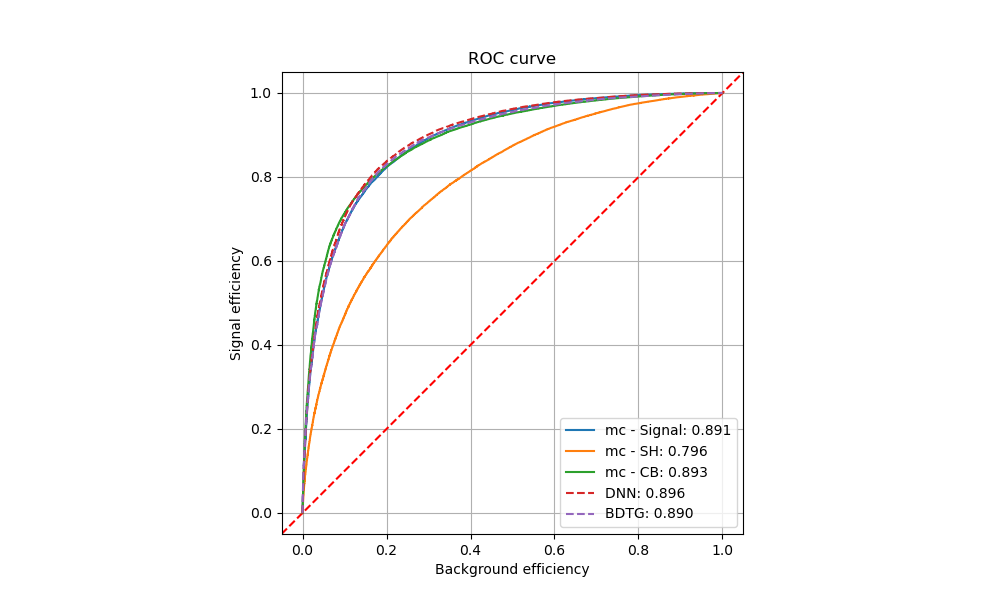

In [3]:
weights = data['weight'].values
target = data['classID'].values

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()
plt.axline((0, 0), slope=1, color='red', linestyle='--')

fpr, tpr, auc_mean = 0, 0, 0
for i in range(3):
    pred = data.iloc[:, i].values
    
    if i == 0:
        roc, auc = roc_auc(pred, target, weight=weights, pos_label=0)
    else:
        mask = (target == 0) | (target == i)
        roc, auc = roc_auc(pred[mask], target[mask], weight=weights[mask], pos_label=0)
        roc = (1 - roc[0], 1 - roc[1])
        auc = 1 - auc
        
    auc_mean += auc
        
    plt.plot(roc[0], roc[1], label=f'{["mc - Signal", "mc - SH", "mc - CB"][i]}: {auc:.3f}')
    
    print(roc)

display(auc_mean/3)    

for mva in ['DNN', 'BDTG']:
    pred = data[mva].values
    (fpr, tpr, threshold), auc = roc_auc(pred, target, weight=weights, pos_label=0)
    plt.plot(fpr, tpr, ls='--', label=f'{mva}: {auc:.3f}')

plt.legend(loc='lower right')
plt.grid()
plt.xlabel('Background efficiency')
plt.ylabel('Signal efficiency')
plt.title('ROC curve')
ax.set_aspect('equal', adjustable='box')

In [4]:
def plot():
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.grid(which='both')
    ax.set_xlim(0, 1)

    weights = data['weight'].values
    true = data['classID'].values

    thresholds = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
    for mva in ['DNN', 'BDTG']:
        pred = data[mva].values
        z = np.zeros_like(thresholds)
        for i, threshold in enumerate(thresholds):
            s = np.sum(weights[true == 0][pred[true == 0] > threshold])
            b = np.sum(weights[true != 0][pred[true != 0] > threshold])
            
            z[i] = Z_score(s, b)
            
        ax.plot(thresholds, z, 'o-', label=mva)
    
    pred = data.loc[:, ['DNN_signal', 'DNN_SH', 'DNN_CB']].values
    for i, (label, color) in enumerate(zip(['Signal vs total background', 'Signal vs single Higgs', 'Signal vs continuum background'], ['blue', 'red', 'green'])):
        z = np.zeros_like(thresholds)
        for j, threshold in enumerate(thresholds):
            if i == 0:
                s = np.sum(weights[true == 0][pred[true == 0][:, i] > threshold])
                b = np.sum(weights[true != 0][pred[true != 0][:, i] > threshold])
            else:
                s = np.sum(weights[true == 0][pred[true == 0][:, i] < threshold])
                b = np.sum(weights[true == i][pred[true == i][:, i] < threshold])
            
            z[j] = Z_score(s, b)
            
        # z /= np.max(z)
        
        ax.plot(thresholds, z, 'o-', label=f'MC - {label}')
    
    fig.legend(fontsize=16, bbox_to_anchor=(1.0, 0.93), loc='upper right', ncol=2)
    
    ax.set_xlabel('MVA score', fontsize=26)
    ax.set_ylabel('Significance', fontsize=26)
    ax.tick_params(axis='both', which='major', labelsize=24)
    ax.set_title(f'Signal significance - {channel}', fontsize=32, pad=100)
    
    fig.tight_layout()

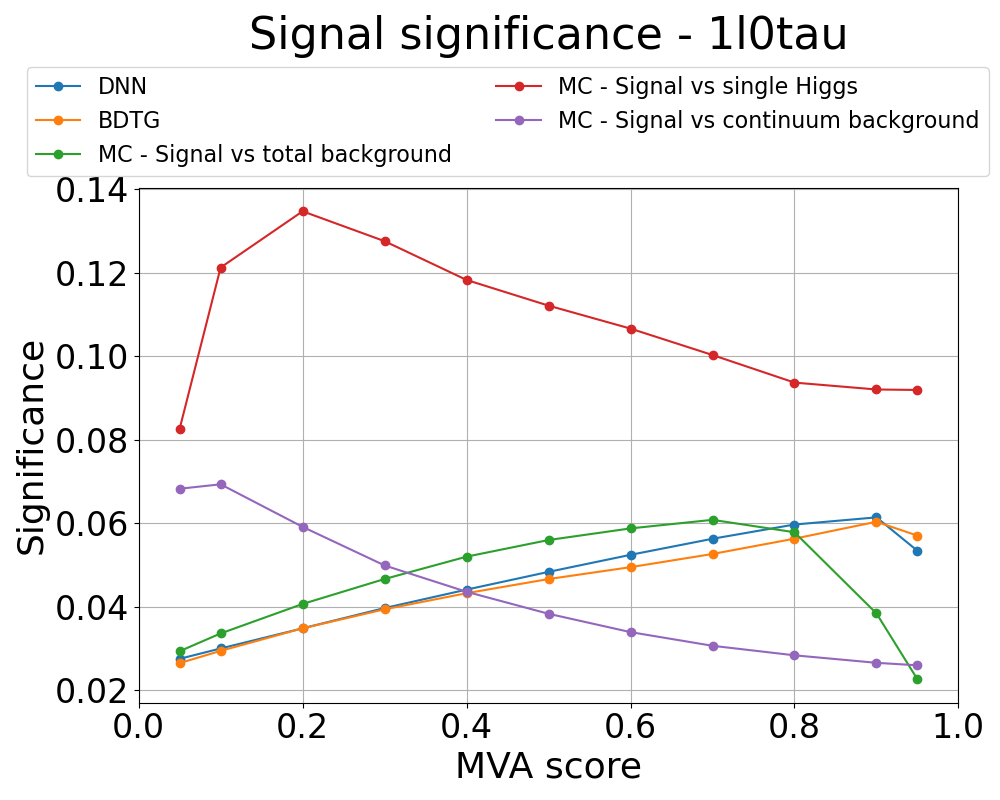

In [5]:
plot()

In [6]:
def cut(
    sig_cut: tuple[float]|float = 0.0,
    sh_cut: tuple[float]|float = 1.0,
    cb_cut: tuple[float]|float = 1.0,
):
    pred = data.loc[:, ['DNN_signal', 'DNN_SH', 'DNN_CB']].values
    weights = data['weight'].values
    true = data['classID'].values
    
    if isinstance(sig_cut, (int, float)):
        sig_cut = (sig_cut, )
        sh_cut = (sh_cut, )
        cb_cut = (cb_cut, )
    
    if len(sig_cut) == 1:
        cut_sig = (pred[true == 0, 0] >= sig_cut[0]) & (pred[true == 0, 1] < sh_cut[0]) & (pred[true == 0, 2] < cb_cut[0])
        cut_sh = (pred[true == 1, 0] >= sig_cut[0]) & (pred[true == 1, 1] < sh_cut[0]) & (pred[true == 1, 2] < cb_cut[0])
        cut_cb = (pred[true == 2, 0] >= sig_cut[0]) & (pred[true == 2, 1] < sh_cut[0]) & (pred[true == 2, 2] < cb_cut[0])
    if len(sig_cut) == 2:
        cut_sig = ((pred[true == 0, 0] >= sig_cut[0]) & (pred[true == 0, 0] < sig_cut[1])) & ((pred[true == 0, 1] < sh_cut[0]) & (pred[true == 0, 1] >= sh_cut[1])) & ((pred[true == 0, 2] < cb_cut[0]) & (pred[true == 0, 2] >= cb_cut[1]))
        cut_sh = ((pred[true == 1, 0] >= sig_cut[0]) & (pred[true == 1, 0] < sig_cut[1])) & ((pred[true == 1, 1] < sh_cut[0]) & (pred[true == 1, 1] >= sh_cut[1])) & ((pred[true == 1, 2] < cb_cut[0]) & (pred[true == 1, 2] >= cb_cut[1]))
        cut_cb = ((pred[true == 2, 0] >= sig_cut[0]) & (pred[true == 2, 0] < sig_cut[1])) & ((pred[true == 2, 1] < sh_cut[0]) & (pred[true == 2, 1] >= sh_cut[1])) & ((pred[true == 2, 2] < cb_cut[0]) & (pred[true == 2, 2] >= cb_cut[1]))
    
    signal = np.sum(weights[true == 0][cut_sig])
    sh = np.sum(weights[true == 1][cut_sh])
    cb = np.sum(weights[true == 2][cut_cb])
    
    return f'Signal: {signal}, Single Higgs: {sh}, Continuum background: {cb}, bkg: {sh + cb}, significance: {Z_score(signal, sh + cb)}'

In [7]:
data.loc[:, ['DNN_signal', 'DNN_SH', 'DNN_CB']].corr()

,DNN_signal,DNN_SH,DNN_CB
DNN_signal,1.000000,-0.487372,-0.650443
DNN_SH,-0.487372,1.000000,-0.346231
DNN_CB,-0.650443,-0.346231,1.000000


In [8]:
s = 0.8

pred = data['DNN'].values
true = data['classID'].values
weight = data['weight'].values

cut_sig = pred[true == 0] >= s
cut_sh = pred[true == 1] >= s
cut_cb = pred[true == 2] >= s

sig = np.sum(weight[true == 0][cut_sig])
sh = np.sum(weight[true == 1][cut_sh])
cb = np.sum(weight[true == 2][cut_cb])

print(f'Signal: {sig}, Single Higgs: {sh}, Continuum background: {cb}, bkg: {sh + cb}, Z: {Z_score(sig, sh + cb)}')

Signal: 0.21918598566356354, Single Higgs: 3.3455139442009085, Continuum background: 10.072349573353645, bkg: 13.417863517554553, Z: 0.059675091820295824


In [9]:
s = 0.5

pred = data['DNN'].values
true = data['classID'].values
weight = data['weight'].values

cut_sig = (pred[true == 0] >= s) & (pred[true == 0] < 0.8)
cut_sh = (pred[true == 1] >= s) & (pred[true == 1] < 0.8)
cut_cb = (pred[true == 2] >= s) & (pred[true == 2] < 0.8)

sig = np.sum(weight[true == 0][cut_sig])
sh = np.sum(weight[true == 1][cut_sh])
cb = np.sum(weight[true == 2][cut_cb])

print(f'Signal: {sig}, Single Higgs: {sh}, Continuum background: {cb}, bkg: {sh + cb}, Z: {Z_score(sig, sh + cb)}')

Signal: 0.09953219218305012, Single Higgs: 4.495904830307466, Continuum background: 25.478955616653245, bkg: 29.97486044696071, Z: 0.018169397842471544


In [10]:
pred = data['DNN'].values
true = data['classID'].values
weight = data['weight'].values

cut_sig = (pred[true == 0] < 0.5)
cut_sh = (pred[true == 1] < 0.5)
cut_cb = (pred[true == 2] < 0.5)

sig = np.sum(weight[true == 0][cut_sig])
sh = np.sum(weight[true == 1][cut_sh])
cb = np.sum(weight[true == 2][cut_cb])

print(f'Signal: {sig}, Single Higgs: {sh}, Continuum background: {cb}, bkg: {sh + cb}, Z: {Z_score(sig, sh + cb)}')

Signal: 0.07309487233748904, Single Higgs: 10.205056582406154, Continuum background: 194.9315597537724, bkg: 205.13661633617855, Z: 0.005103094224378234


In [11]:
def split(pred, weights, true, index = 0, ge=None, lt=None):
    if ge is not None:
        mask = pred[:, index] >= ge
    elif lt is not None:
        mask = pred[:, index] < lt
    else:
        raise ValueError('Either ge or lt must be provided')
    
    return pred[mask], weights[mask], true[mask]
    

In [12]:
pred = data.loc[:, ['DNN_signal', 'DNN_SH', 'DNN_CB']].values
weights = data['weight'].values
true = data['classID'].values

pred, weights, true = split(pred, weights, true, index=0, ge=0.9)
pred, weights, true = split(pred, weights, true, index=1, lt=1)
pred, weights, true = split(pred, weights, true, index=2, lt=0.1)

s = np.sum(weights[true == 0])
b = np.sum(weights[true != 0])

s_tot, b_tot = s, b

s, b, Z_score(s, b)

(0.03409079515077942, 0.7782683090807527, 0.03836491345115562)

In [13]:
pred = data.loc[:, ['DNN_signal', 'DNN_SH', 'DNN_CB']].values
weights = data['weight'].values
true = data['classID'].values

mask = ((pred[:, 0] < 0.6) & (pred[:, 0] >= 0.35)) | ((pred[:, 2] < 0.4) & (pred[:, 2] >= 0.2))
mask = ((pred[:, 0] < 0.9) & (pred[:, 0] >= 0.2)) & ((pred[:, 2] < 0.3) & (pred[:, 2] >= 0.1))
# mask = (pred[:, 0] < 0.6) & (pred[:, 0] >= 0.35)
pred = pred[mask]
weights = weights[mask]
true = true[mask]

s = np.sum(weights[true == 0])
b = np.sum(weights[true != 0])

s_tot += s
b_tot += b

s, b, Z_score(s, b)

(0.09854620432991967, 22.322036956153926, 0.020842484892595957)

In [14]:
pred = data.loc[:, ['DNN_signal', 'DNN_SH', 'DNN_CB']].values
weights = data['weight'].values
true = data['classID'].values

mask = ((pred[:, 0] < 0.35) | (pred[:, 1] >= 0.8) | (pred[:, 2] >= 0.2))# | ((pred[:, 1] >= 0.4) & (pred[:, 0] < 0.35) & (pred[:, 2] >= 0.4)) | ((pred[:, 2] >= 0.4) & (pred[:, 0] < 0.35) & (pred[:, 1] >= 0.4))
pred = pred[mask]
weights = weights[mask]
true = true[mask]

s = np.sum(weights[true == 0])
b = np.sum(weights[true != 0])

s_tot += s
b_tot += b

s, b, Z_score(s, b), s_tot, b_tot

(0.14086567411425174,
 230.32692135603037,
 0.00928080149246541,
 0.27350267359495084,
 253.42722662126505)

In [15]:
pred = data.loc[:, ['DNN_signal', 'DNN_SH', 'DNN_CB']].values
weights = data['weight'].values
true = data['classID'].values

s = np.sum(weights[true == 0])
b = np.sum(weights[true != 0])

s, b, Z_score(s, b)

(0.3918130501841027, 248.52934030069375, 0.024847053873589365)

In [16]:
pred = data.loc[:, ['DNN_signal', 'DNN_SH', 'DNN_CB']].values
weights = data['weight'].values
true = data['classID'].values

pred, weights, true = split(pred, weights, true, index=0, lt=0.6)
pred, weights, true = split(pred, weights, true, index=0, ge=0.35)

s = np.sum(weights[true == 0])
b = np.sum(weights[true != 0])

s_tot += s
b_tot += b

s, b, Z_score(s, b), s_tot, b_tot

(0.09586466484027731,
 24.735394271247443,
 0.019262579287438797,
 0.3693673384352282,
 278.1626208925125)

In [17]:
n = 100

a = np.arange(0, n, 1, dtype=float)
b = np.random.uniform(0, 1, n)
c = np.random.uniform(0, 1, n)
d = np.random.uniform(0, 1, n)

In [18]:
q = a[(b >= 0.6) & (c < 0.4)]
w = a[(b < 0.6) & (b >= 0.2) & (c < 0.4)]
e = a[(b < 0.2) | (c >= 0.4)]

display(q, w, e)

q.shape, w.shape, e.shape

array([ 4., 11., 26., 28., 29., 30., 31., 50., 54., 57., 66., 91.])

array([ 1.,  6.,  7., 12., 22., 24., 27., 43., 53., 65., 67., 69., 72.,
       75., 77., 78., 84., 85., 89.])

array([ 0.,  2.,  3.,  5.,  8.,  9., 10., 13., 14., 15., 16., 17., 18.,
       19., 20., 21., 23., 25., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 44., 45., 46., 47., 48., 49., 51., 52., 55., 56.,
       58., 59., 60., 61., 62., 63., 64., 68., 70., 71., 73., 74., 76.,
       79., 80., 81., 82., 83., 86., 87., 88., 90., 92., 93., 94., 95.,
       96., 97., 98., 99.])

((12,), (19,), (69,))

Text(95.72222222222221, 0.5, 'DNN_signal threshold')

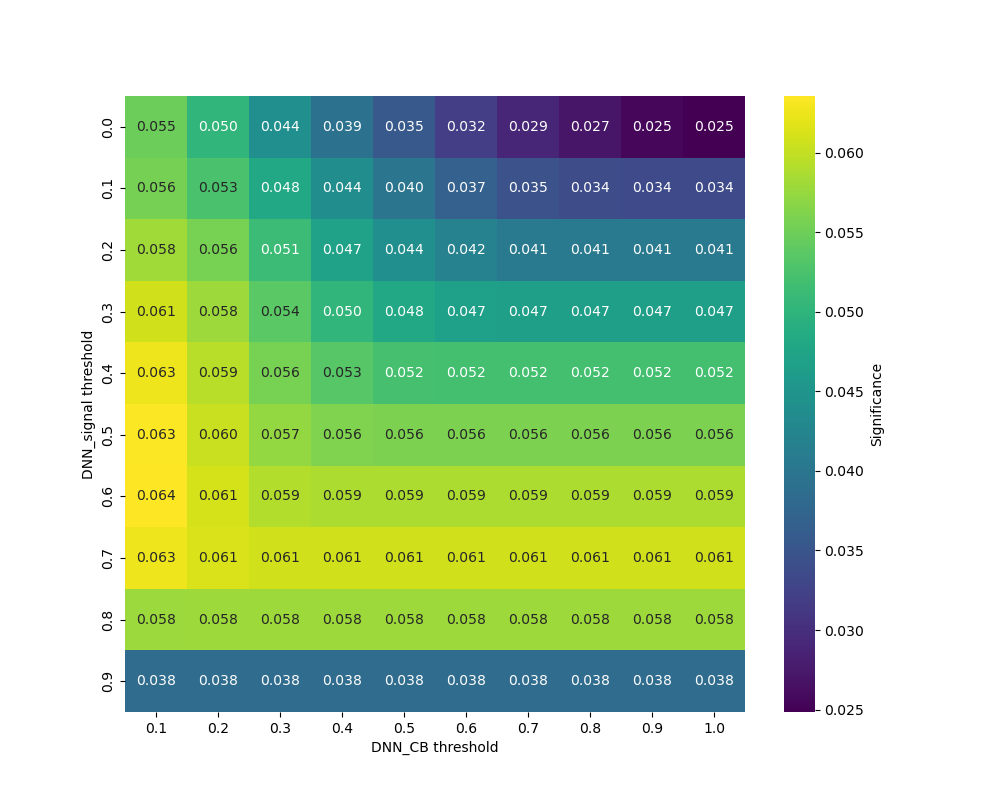

In [19]:
pred = data.loc[:, ['DNN_signal', 'DNN_CB']].values
weights = data['weight'].values
true = data['classID'].values

sig_thresholds = np.arange(0, 1.0, 0.1)
cb_thresholds = np.arange(0.1, 1.01, 0.1)
z = np.zeros((len(sig_thresholds), len(cb_thresholds)))
for xi, xs in enumerate(sig_thresholds):
    for yi, ys in enumerate(cb_thresholds):
        mask = (pred[:, 0] >= xs) & (pred[:, 1] < ys)
        s = np.sum(weights[mask][true[mask] == 0])
        b = np.sum(weights[mask][true[mask] != 0])
        
        z[xi, yi] = Z_score(s, b)
        
plt.figure(figsize=(10, 8))
sns.heatmap(
    z, 
    xticklabels=[f'{x:.1f}' for x in cb_thresholds],
    yticklabels=[f'{y:.1f}' for y in sig_thresholds],
    cmap='viridis', 
    cbar_kws={'label': 'Significance'}, 
    annot=True, 
    fmt='.3f'
)

plt.xlabel('DNN_CB threshold')
plt.ylabel('DNN_signal threshold')

Text(95.72222222222221, 0.5, 'DNN_signal threshold')

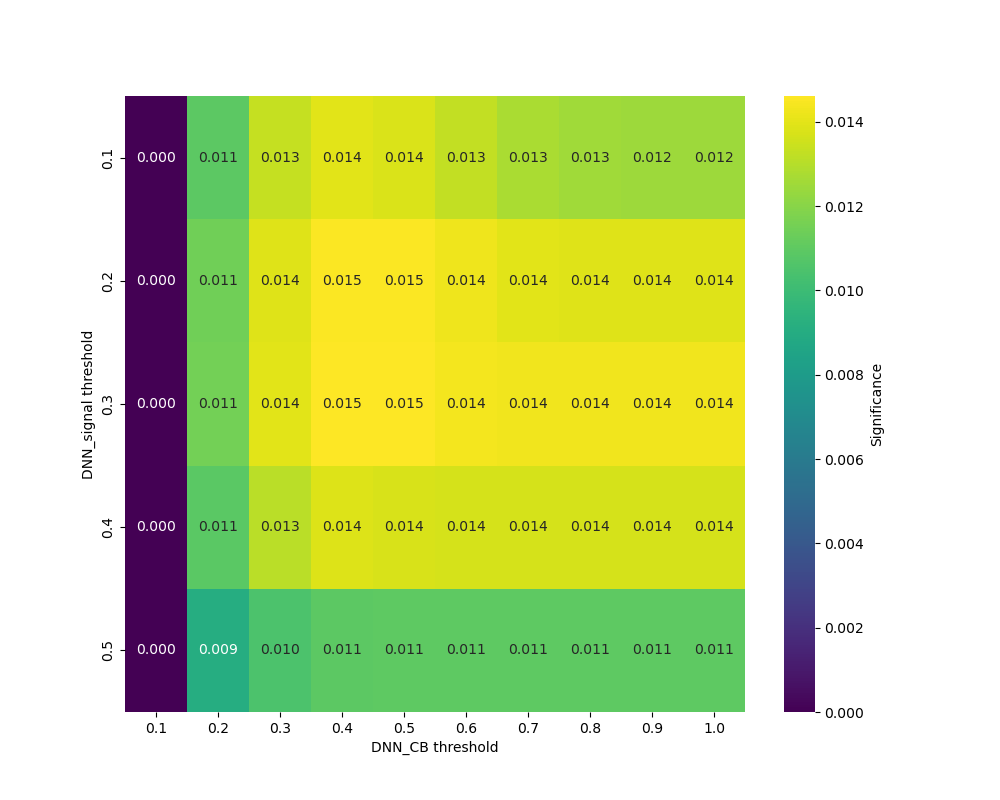

In [20]:
sig_max = 0.6
cb_min = 0.1

sig_thresholds = np.arange(0.1, sig_max, 0.1)
cb_thresholds = np.arange(cb_min, 1.1, 0.1)

z = np.zeros((len(sig_thresholds), len(cb_thresholds)))
for xi, xs in enumerate(sig_thresholds):
    for yi, ys in enumerate(cb_thresholds):
        mask = (pred[:, 0] >= xs) & (pred[:, 0] < sig_max) & (pred[:, 1] < ys) & (pred[:, 1] >= cb_min)
        s = np.sum(weights[mask][true[mask] == 0])
        b = np.sum(weights[mask][true[mask] != 0])
        
        z[xi, yi] = Z_score(s, b)
        
plt.figure(figsize=(10, 8))
sns.heatmap(
    z, 
    xticklabels=[f'{x:.1f}' for x in cb_thresholds],
    yticklabels=[f'{y:.1f}' for y in sig_thresholds],
    cmap='viridis', 
    cbar_kws={'label': 'Significance'}, 
    annot=True, 
    fmt='.3f'
)

plt.xlabel('DNN_CB threshold')
plt.ylabel('DNN_signal threshold')

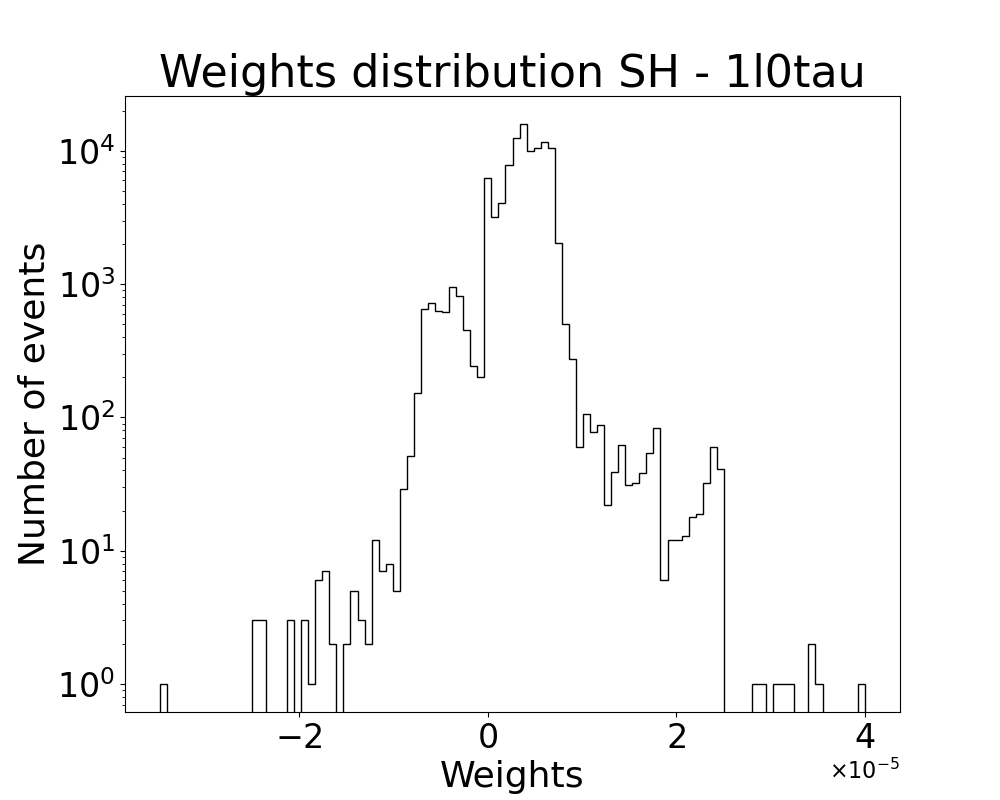

In [33]:
from matplotlib import ticker

with uproot.open('../Output/Files/signal_ggF_1l0tau.root') as f:
    weights = f['output']['weight'].array(library='np')


fig, ax = plt.subplots(figsize=(10, 8))
    
ax.ticklabel_format(axis='x', style='sci', scilimits=(-3, 1), useMathText=True)

ax.hist(weights, bins=100, histtype='step', color='black')
ax.set_yscale('log')

ax.set_xlabel('Weights', fontsize=26)
ax.set_ylabel('Number of events', fontsize=26)
ax.set_title(f'Weights distribution SH - {channel}', fontsize=32)

ax.tick_params(axis='both', which='major', labelsize=24)
ax.xaxis.offsetText.set_fontsize(16)